# Проект: Анализ бизнес-показателей.

**Инструкция по выполнению проекта:**

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

## Загрузим данные и подготовим их к анализу

In [1]:
# Загрузим библиотеки

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# Загрузим данные

visits = pd.read_csv('/datasets/visits_info_short.csv') # данные о визитах
orders = pd.read_csv('/datasets/orders_info_short.csv')  # данные о заказах
costs = pd.read_csv('/datasets/costs_info_short.csv')   # данные о расходах

In [3]:
# приводим названия столбцов к нижнему регистру
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

# переимениум столбцы вставив вместо пропуска нижнее подчеркивание
visits.rename(columns = {'user id': 'user_id',
                         'session start': 'session_start', 
                         'session end': 'session_end'}, inplace=True)
orders.rename(columns = {'user id': 'user_id',
                        'event dt': 'event_dt'}, inplace=True)

In [4]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date


In [5]:
# Проверим на наличие дубликатов
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


In [6]:
# просмотрим данные
display(visits.head())
display(orders.head())
display(costs.head())

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


**Описание данных**

Таблица visits:

    user_id — уникальный идентификатор пользователя
    device — категория устройства пользователя
    session_start — дата и время начала сессии
    session_end — дата и время окончания сессии
    channel — идентификатор рекламного источника, из которого пришел пользователь
    region - страна пользователя

Таблица order:

    user_id — уникальный id пользователя, который сделал заказ
    event_dt — дата и время покупки
    revenue — выручка

Таблица costs:

    channel — идентификатор рекламного источника
    dt — дата
    costs — затраты на этот рекламный источник в этот день

Краткий вывод:
* привели название всех столбцов к нижнему регистру
* проверили на отсутствие дубликатов
* преобразовали данные о времени

## Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии.

In [7]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [8]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [9]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [10]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [11]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

 #   # во второй ячейке строим кривые удержания неплатящих
 #   # вертикальная ось — от графика из первой ячейки
 #   ax2 = plt.subplot(2, 2, 2, sharey=ax1)
 #   retention.query('payer == False').droplevel('payer').T.plot(
 #       grid=True, ax=ax2
 #   )
 #   plt.legend()
 #   plt.xlabel('Лайфтайм')
 #   plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
 #   ax3 = plt.subplot(2, 2, 3)
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

  #  # в чётвертой ячейке — динамика удержания неплатящих
  #  ax4 = plt.subplot(2, 2, 4, sharey=ax3)
  #  # фильтруем данные и строим график
  #  filtered_data = retention_history.query('payer == False').pivot_table(
  #      index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
  #  )
  #  filter_data(filtered_data, window).plot(grid=True, ax=ax4)
  #  plt.xlabel('Дата привлечения')
  #  plt.title(
  #      'Динамика удержания неплатящих пользователей на {}-й день'.format(
  #          horizon
  #      )
  #  )
    
    plt.tight_layout()
    plt.show()


In [12]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [13]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [14]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

## Проведем исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

In [15]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, 0, costs)

#посмотрим на таблицу
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [16]:
min_date = profiles['first_ts'].min().date()
max_date = profiles['first_ts'].max().date()
print('Минимальная дата привлечения пользователей:', min_date)
print()
print('Максимальная дата привлечения пользователей:', max_date)

Минимальная дата привлечения пользователей: 2019-05-01

Максимальная дата привлечения пользователей: 2019-10-27


Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [17]:
print('Распределение платящих клиентов по странам')
region_rev = (profiles.query('payer == True')
        .groupby('region')
        .agg({'user_id' : 'count'})
        .sort_values(by='user_id', ascending=False))
region_all = (profiles
        .groupby('region')
        .agg({'user_id' : 'count'})
        .sort_values(by='user_id', ascending=False))
region_result = region_all.merge(region_rev, on='region', how='left')
region_result.rename(columns = {'user_id_x': 'users', 
                                 'user_id_y': 'paying_users'}, inplace=True)
region_result['share_playing'] = region_result['paying_users'] / region_result['users']
region_result.sort_values(by='share_playing', ascending=False).round(3)

Распределение платящих клиентов по странам


,users,paying_users,share_playing
region,,,
United States,100002,6902,0.069
Germany,14981,616,0.041
UK,17575,700,0.040
France,17450,663,0.038


In [18]:
print('Распределение платящих клиентов по используемым устройствам')
device_rev = (profiles.query('payer == True')
        .groupby('device')
        .agg({'user_id' : 'count'})
        .sort_values(by='user_id', ascending=False))
device_all = (profiles
        .groupby('device')
        .agg({'user_id' : 'count'})
        .sort_values(by='user_id', ascending=False))
device_result = device_all.merge(device_rev, on='device', how='left')
device_result.rename(columns = {'user_id_x': 'users', 
                                 'user_id_y': 'paying_users'}, inplace=True)
device_result['share_playing'] = device_result['paying_users'] / device_result['users']
device_result.sort_values(by='share_playing', ascending=False).round(3)

Распределение платящих клиентов по используемым устройствам


,users,paying_users,share_playing
device,,,
Mac,30042,1912,0.064
iPhone,54479,3382,0.062
Android,35032,2050,0.059
PC,30455,1537,0.050


In [19]:
print('Распределение платящих клиентов по каналам привлечения')
channel_rev = (profiles.query('payer == True')
        .groupby('channel')
        .agg({'user_id' : 'count'})
        .sort_values(by='user_id', ascending=False))
channel_all = (profiles
        .groupby('channel')
        .agg({'user_id' : 'count'})
        .sort_values(by='user_id', ascending=False))
channel_result = channel_all.merge(channel_rev, on='channel', how='left')
channel_result.rename(columns = {'user_id_x': 'users', 
                                 'user_id_y': 'paying_users'}, inplace=True)
channel_result['share_playing'] = channel_result['paying_users'] / channel_result['users']
channel_result.sort_values(by='share_playing', ascending=False).round(3)

Распределение платящих клиентов по каналам привлечения


,users,paying_users,share_playing
channel,,,
FaceBoom,29144,3557,0.122
AdNonSense,3880,440,0.113
lambdaMediaAds,2149,225,0.105
TipTop,19561,1878,0.096
RocketSuperAds,4448,352,0.079
WahooNetBanner,8553,453,0.053
YRabbit,4312,165,0.038
MediaTornado,4364,156,0.036
LeapBob,8553,262,0.031


**Промежуточные выводы:**

* Больше всего платящих пользователей (ПП) из США. Доля ПП в США больше чем в других странах почти в 2 раза.
* Самое популярное устройство - iPhone. Доля ПП у iPhone и Mac чуть выше, чем у других устройств. 
* Самый лучший канал привлечения клиентов - FaceBoom. Каналы с более высокой долей ПП: FaceBoom, AdNonSense, lambdaMediaAds и TipTop.

## Маркетинг

**Выясним: Сколько денег потратили? Всего / на каждый источник / по времени.**

In [20]:
print('Всего потратили:', profiles['acquisition_cost'].sum().round(1))

Всего потратили: 105497.3


In [21]:
print('Распределение трат в зависимости от источника' )
display(costs
        .groupby('channel')
        .agg({'costs' : 'sum'})
        .sort_values(by='costs', ascending=False)
        .round(1)
)

Распределение трат в зависимости от источника


,costs
channel,
TipTop,54751.3
FaceBoom,32445.6
WahooNetBanner,5151.0
AdNonSense,3911.2
OppleCreativeMedia,2151.2
RocketSuperAds,1833.0
LeapBob,1797.6
lambdaMediaAds,1557.6
MediaTornado,954.5


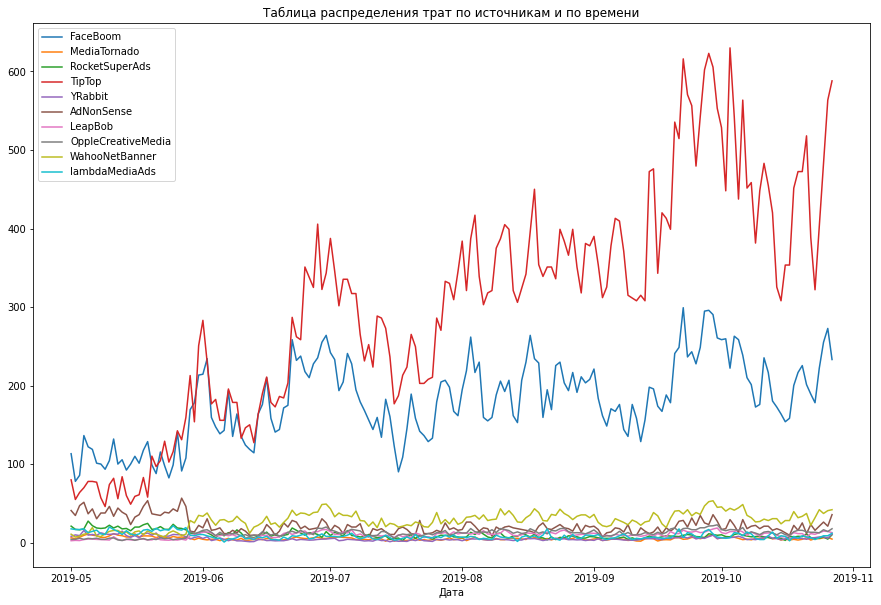

In [22]:
plt.figure(figsize=(15, 10))
costs_dt = costs.pivot_table(index=['channel','dt'], values='costs', aggfunc='sum').reset_index()
channels = costs['channel'].unique()
for channel in channels:
    plt.plot(costs_dt.query('channel==@channel')['dt'], costs_dt.query('channel==@channel')['costs'], label=channel)
plt.legend()
plt.xlabel('Дата')
plt.title('Таблица распределения трат по источникам и по времени')
plt.show()

**Выясним:  Сколько в среднем стоило привлечение одного покупателя из каждого источника?**

In [23]:
print('Средняя стоимость привлечение одного пользователя из каждого источника' )
(profiles.query('payer == True')
        .groupby('channel')
        .agg({'acquisition_cost' : 'mean'})
        .sort_values(by='acquisition_cost', ascending=False)
        .round(2)
        .rename(columns={'acquisition_cost': 'mean'}))  

Средняя стоимость привлечение одного пользователя из каждого источника


,mean
channel,
TipTop,2.79
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.74
WahooNetBanner,0.60
RocketSuperAds,0.42
OppleCreativeMedia,0.25
MediaTornado,0.22
YRabbit,0.21


In [24]:
# расчитаем средний CAC на одного пользователя для всего проекта
cac_mean_all = (profiles.query('payer == True')
                        .query('channel != "organic"')
                        .agg({'acquisition_cost' : 'mean'})
                        .round(2))

print('Cредний CAC на одного пользователя для всего проекта:', cac_mean_all[0])

Cредний CAC на одного пользователя для всего проекта: 1.35


Выводы: 
* Самые дорогие каналы привлечения: TipTop и FaceBoom.
* У TipTop средняя стоимость привлечения в 2 раза выше, чем средняя CAC для всего проекта.

## Оценим окупаемость рекламы для привлечения пользователей.

### Проанализируем общую окупаемость рекламы.

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

Установим момент и горизонт анализа данных.

In [25]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

При дальнейшем анализе исключим органических пользователей.

In [26]:
profiles = profiles.query('channel != "organic"')

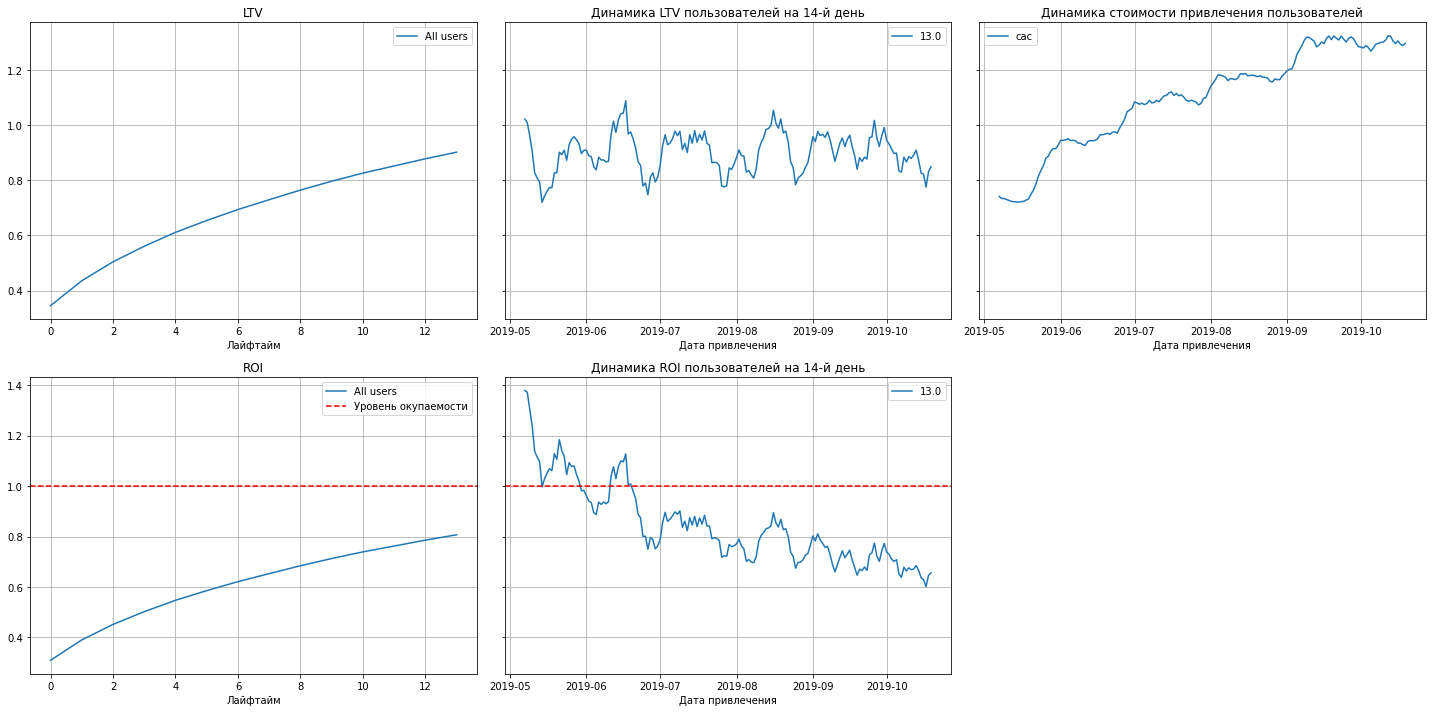

In [27]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:

* Реклама не окупается. ROI в конце двух недель около 80%.
* На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. 
* Динамика стоимости привлечения пользователей растет.

### Проанализируем окупаемость рекламы с разбивкой по устройствам.

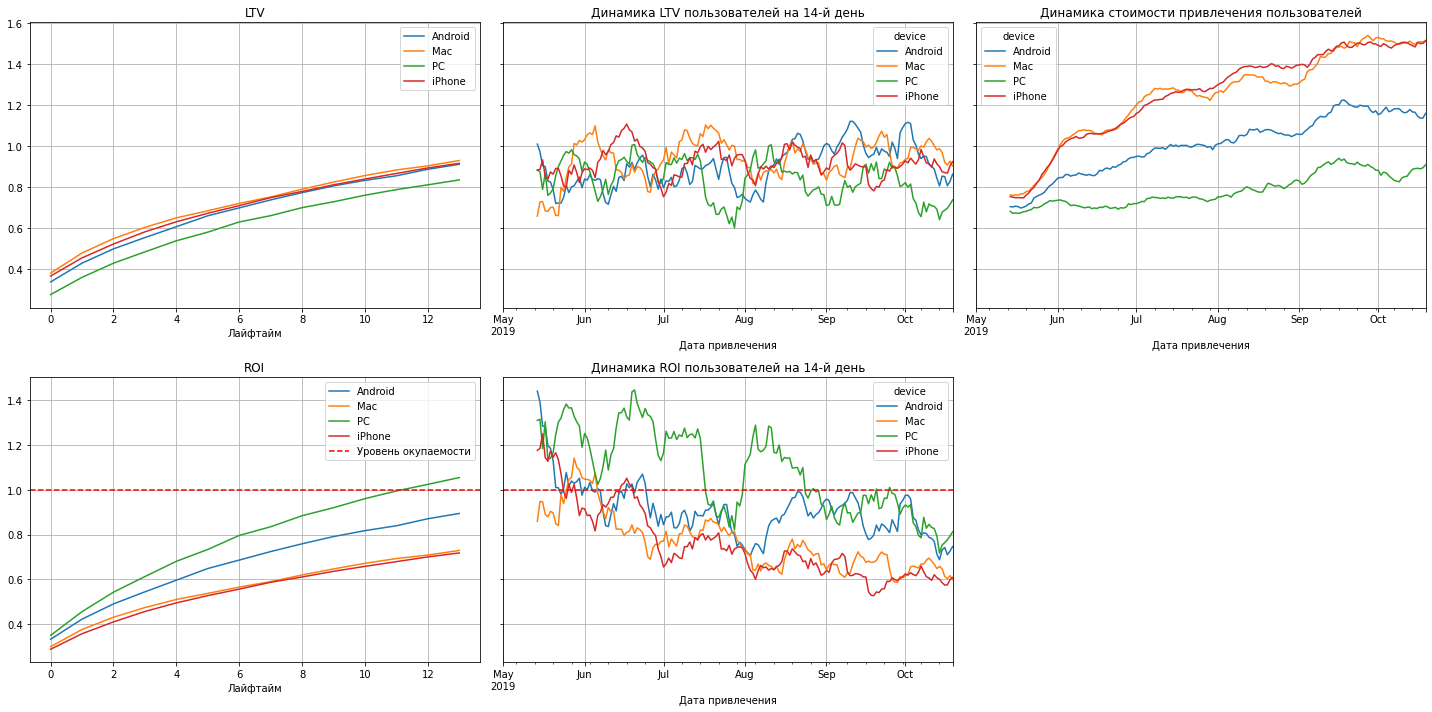

In [28]:
# посмотрим на окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Проанализируем графики.

* Динамика стоимости привлечения пользователей растет, особенно у пользователей Mac и iPhone.
* Окупаются только пользователи PC. Аутсайдеры Mac и iPhone с 72% окупаемости.

### Проанализируем окупаемость рекламы с разбивкой по странам.

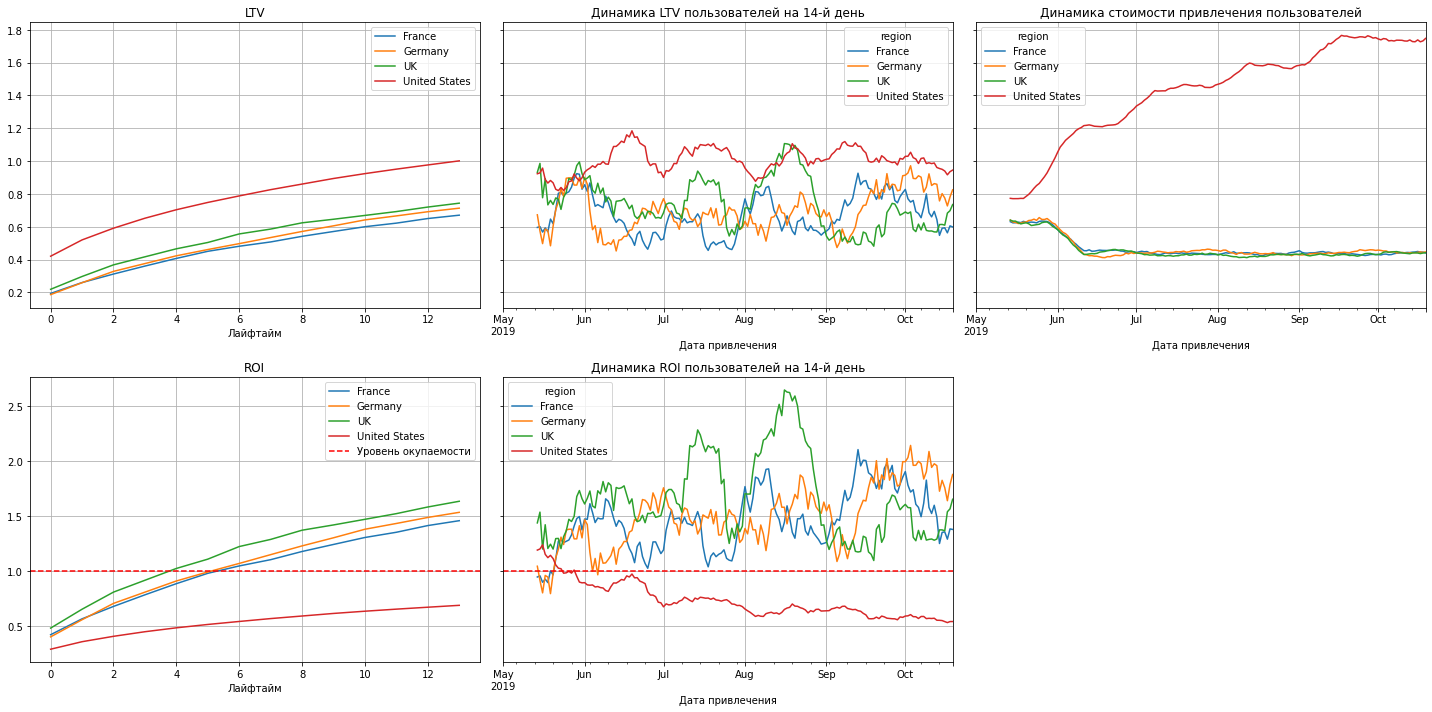

In [29]:
# посмотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вот что говорят графики:

* Проблема с пользователями из США. Динамика стоимости привлечения растет каждый месяц, а ROI к концу двух недель только около 70%.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

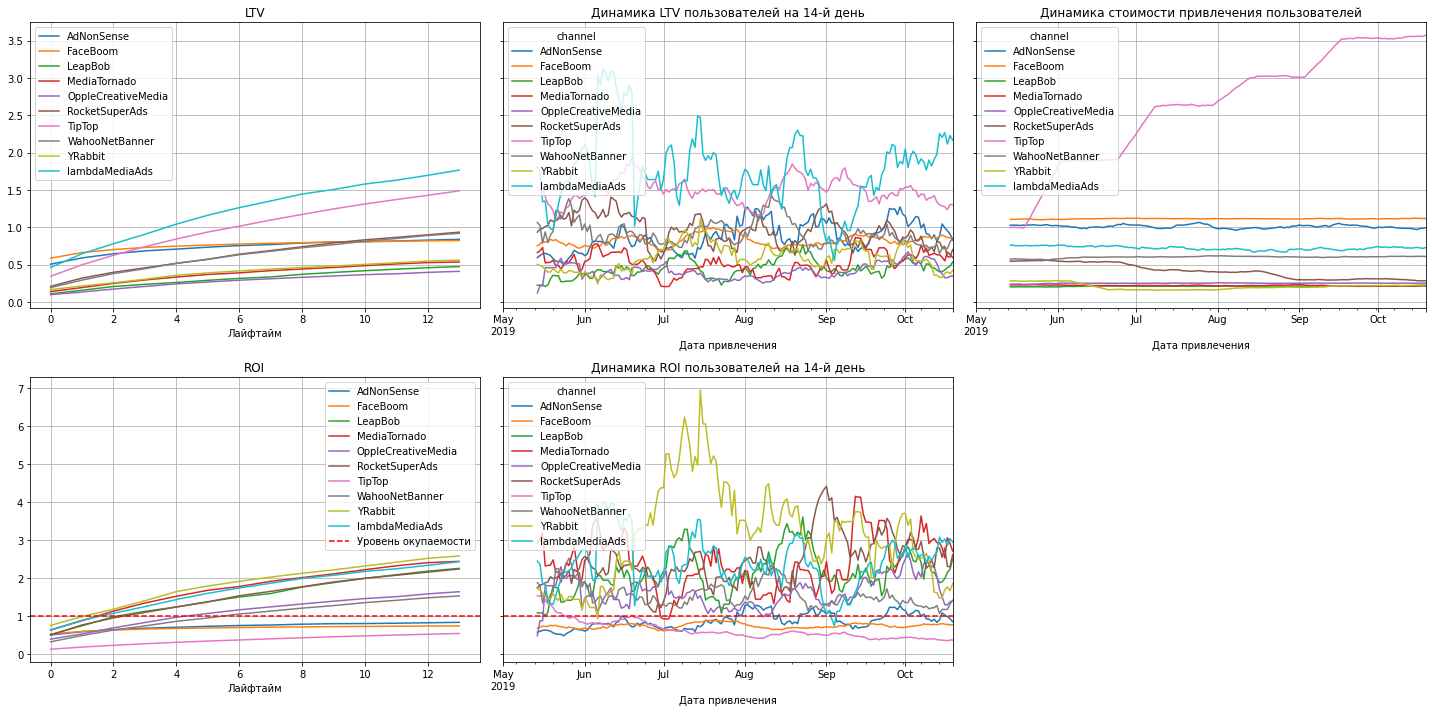

In [30]:
# смотрим окупаемость с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Делаем выводы.

* Динамика стоимости привлечения пользователей каналом TipTop отличается от остальных каналов и растет каждый месяц.
* Каналы TipTop, FaceBoom и AdNonSense не окупаются.

Изучим США более детально.

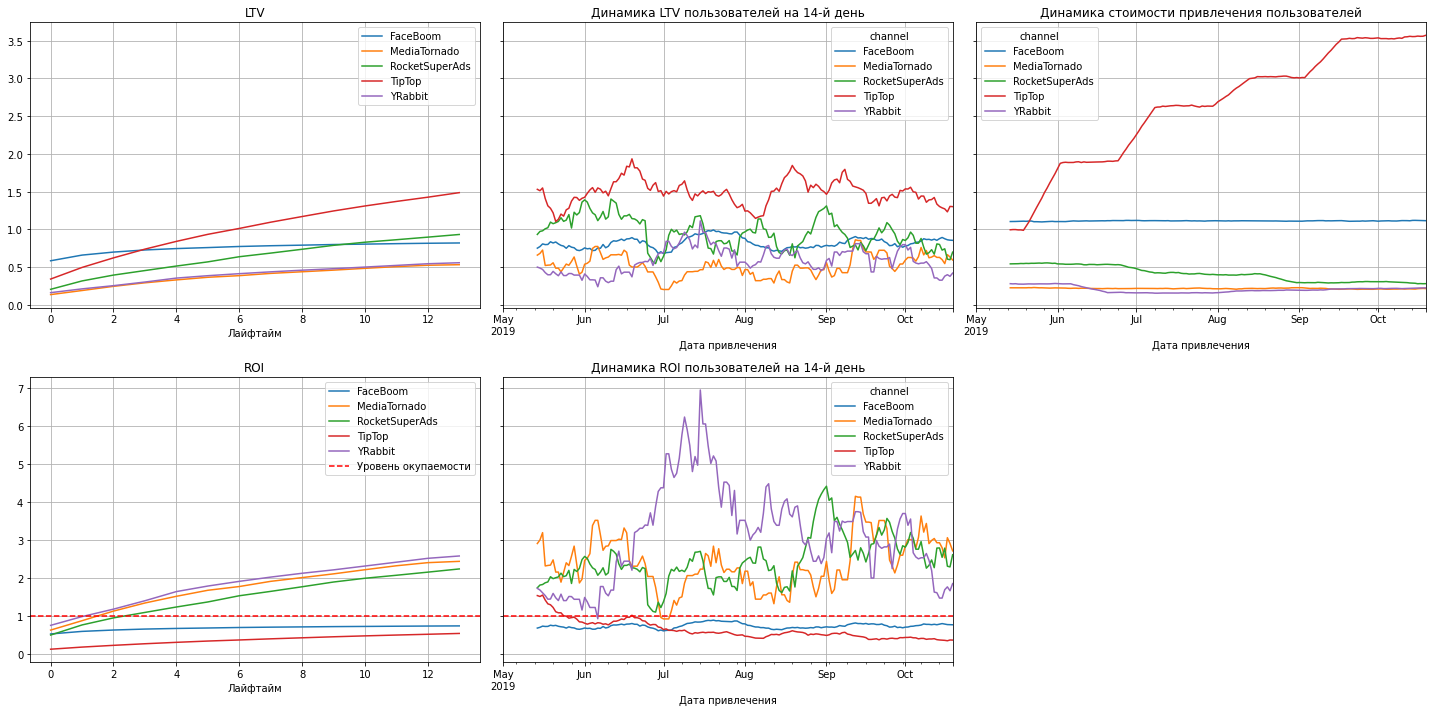

In [31]:
# смотрим окупаемость с разбивкой по рекламным каналам только для США.

dimensions = ['channel']
profiles_usa = profiles.query('region=="United States"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Выводы по США.
* Каналы TipTop и FaceBoom не окупаются, хотя у них самая высокая динамика CAC.
* Остальные каналы окупаются на третий день. 

Рассмотрим Европу более детально.


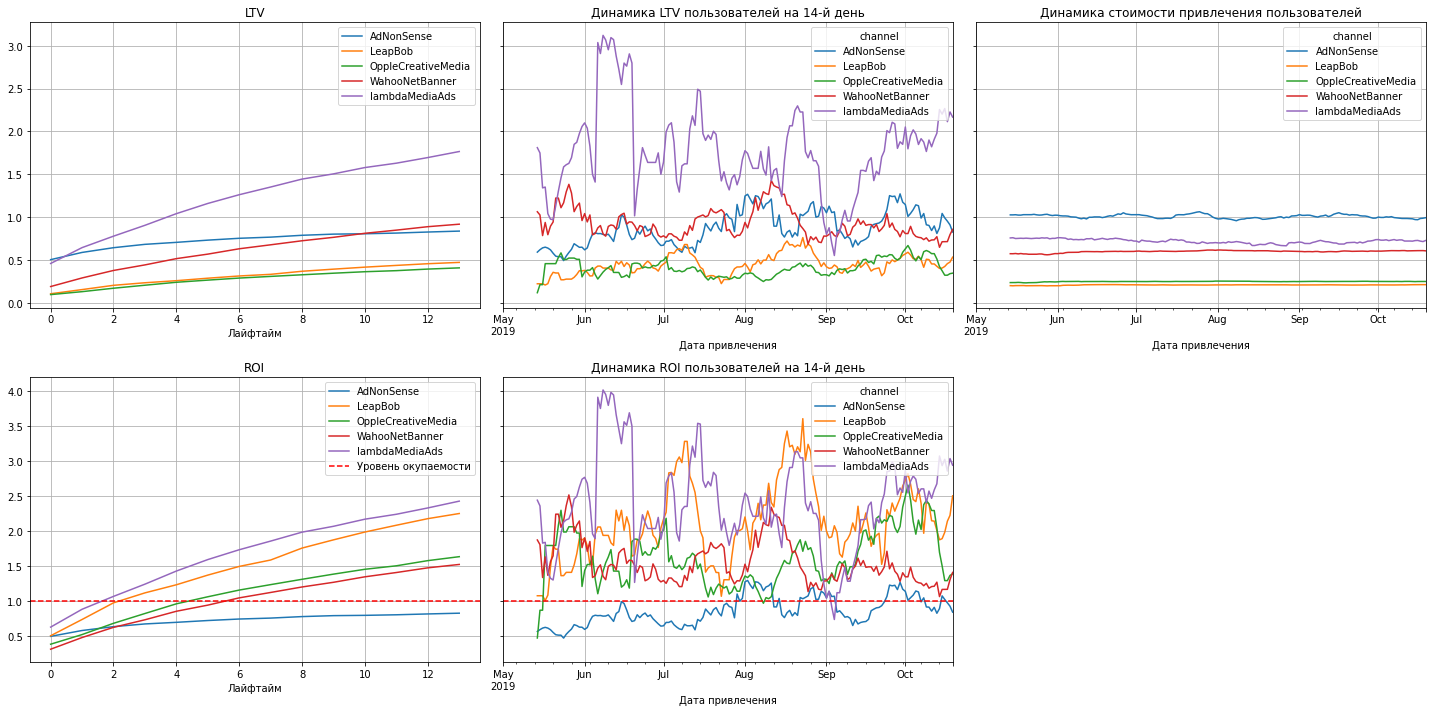

In [32]:
# смотрим окупаемость с разбивкой по рекламным каналам только для США.

dimensions = ['channel']
profiles_no_usa = profiles.query('region!="United States"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вывод по Европе.
* Канал AdNonSense не окупается.
* Канал lambdaMediaAds имеет высокую LTV и самую высокую ROI.

### Постройте и изучите графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

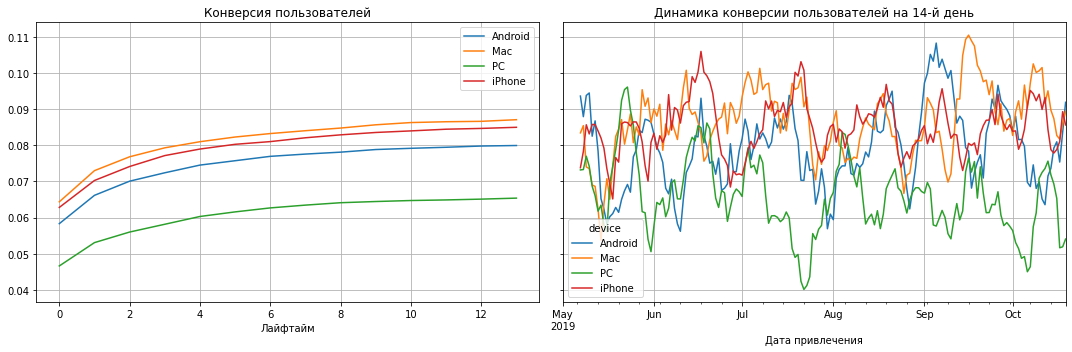

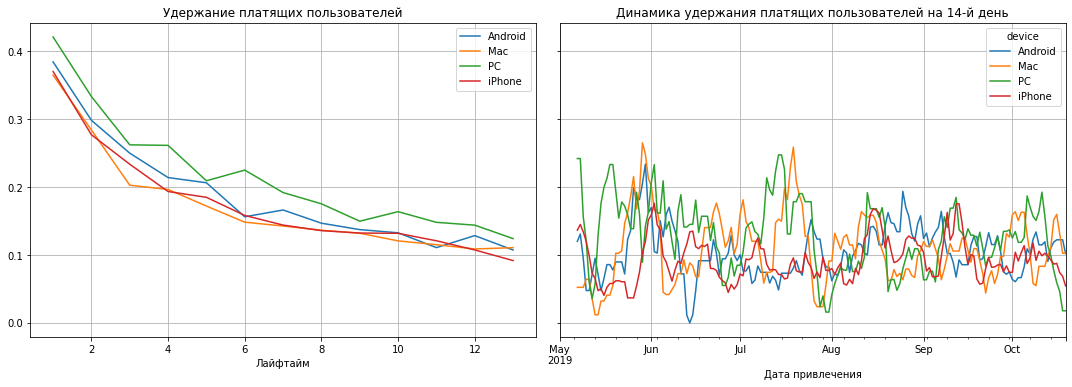

In [33]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions)

# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions)


plot_conversion(conversion_grouped, conversion_history, horizon_days)
plot_retention(retention_grouped, retention_history, horizon_days) 


Выводы

* Хуже всего конвертируются пользователи с PC. А удержание у всех примерно одинаковое.

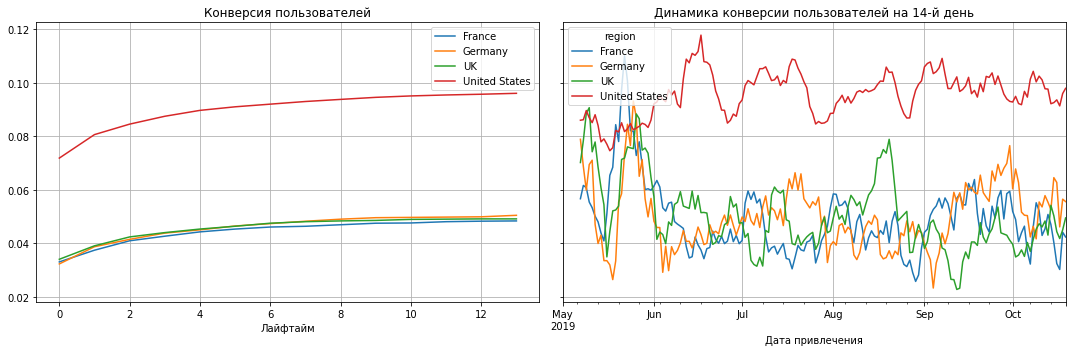

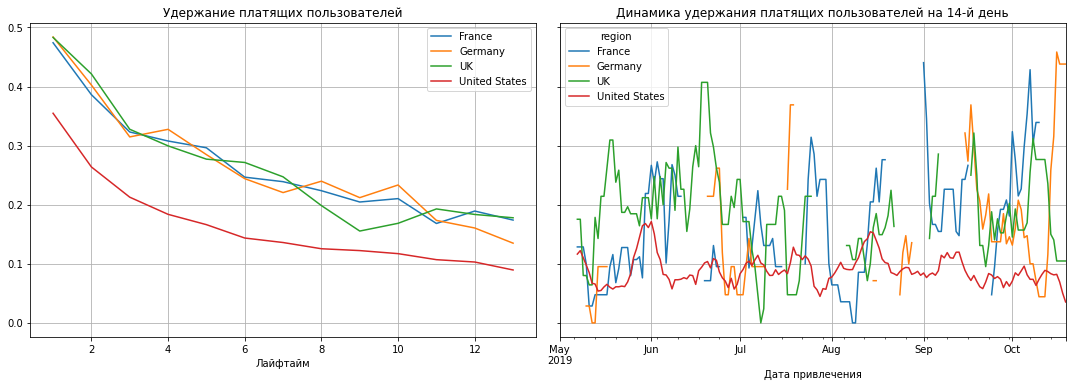

In [34]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions)

# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions)


plot_conversion(conversion_grouped, conversion_history, horizon_days)
plot_retention(retention_grouped, retention_history, horizon_days) 

Вывод:

* Лучше всех конвертируются пользователи из США, а с удержанием у них хуже всех.

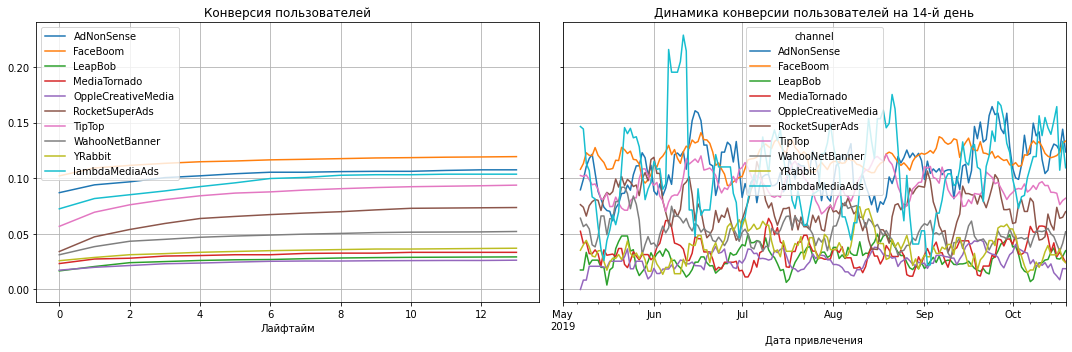

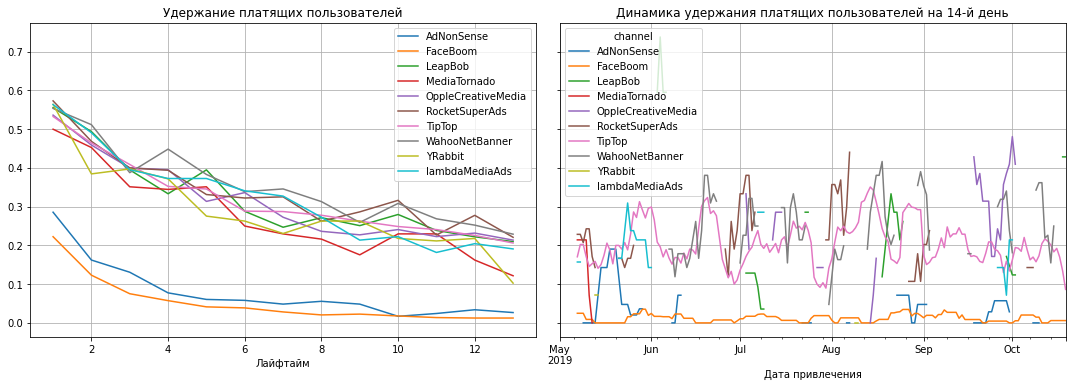

In [35]:
# смотрим конверсию с разбивкой по рекламным каналам
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions)

# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions)


plot_conversion(conversion_grouped, conversion_history, horizon_days)
plot_retention(retention_grouped, retention_history, horizon_days) 

Вывод:

* Проблемы с каналами AdNonSense и FaceBoom. При самой высокой конверсии имеют самое низкое удержание.

Изучим США более подробно

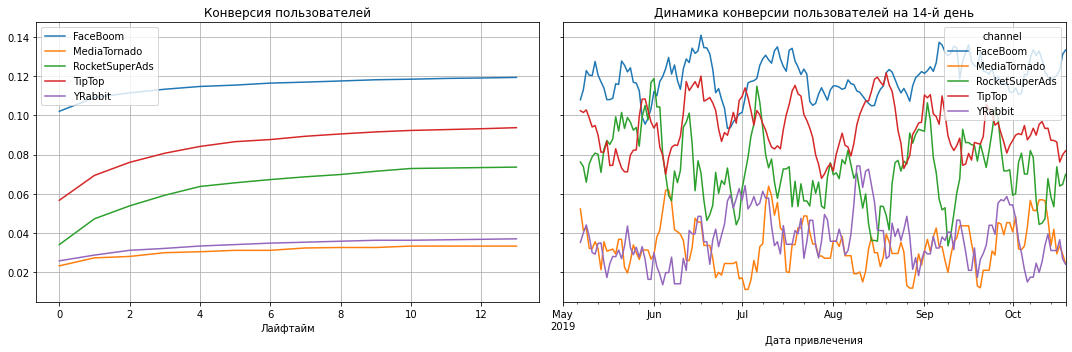

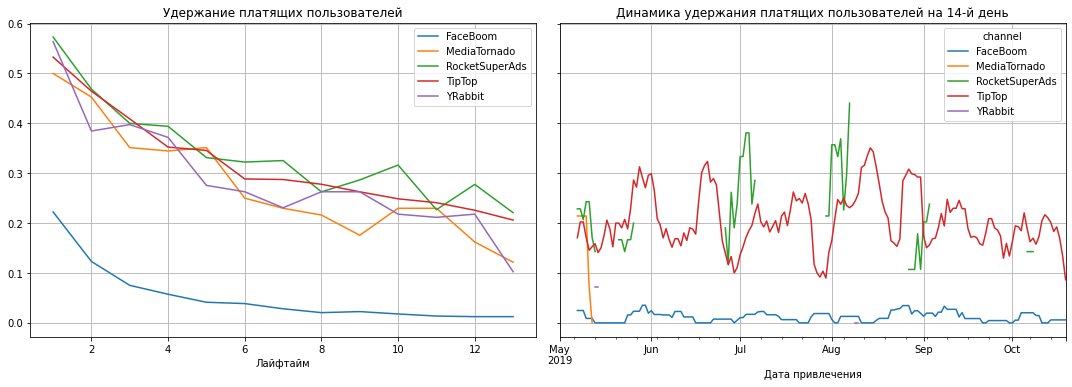

In [36]:
# смотрим конверсию с разбивкой по рекламным каналам только в США
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions = dimensions)

# смотрим удержание с разбивкой по рекламным каналам только в США

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions = dimensions)


plot_conversion(conversion_grouped, conversion_history, horizon_days)
plot_retention(retention_grouped, retention_history, horizon_days) 

Выводы по США.
* Каналы в высокой конверсией: FaceBoom, TipTop и RocketSuperAds.
* Cамое низкое удержание у FaceBoom.

Изучим Европу более детально.

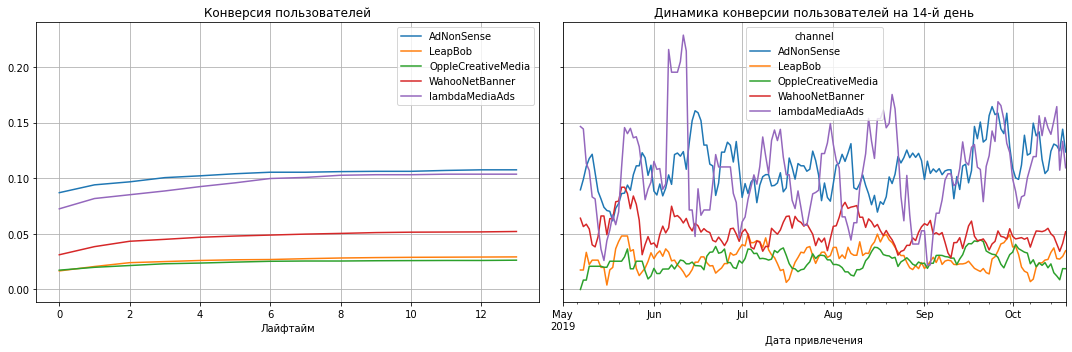

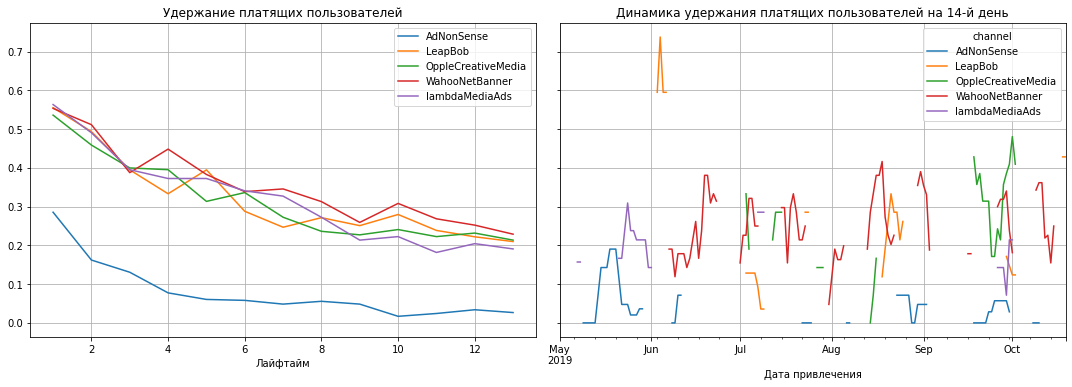

In [37]:
# смотрим конверсию с разбивкой по рекламным каналам только в США
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_usa, orders, observation_date, horizon_days, dimensions = dimensions)

# смотрим удержание с разбивкой по рекламным каналам только в США

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no_usa, visits, observation_date, horizon_days, dimensions = dimensions)


plot_conversion(conversion_grouped, conversion_history, horizon_days)
plot_retention(retention_grouped, retention_history, horizon_days) 

Выводы по Европе.
* Каналы lambdaMediaAds и AdNonSense имеют высокую конверсию.
* У канала AdNonSense самое низкое удержание.

Промежуточный вывод по окупаемости рекламы.
* Реклама не окупается. ROI в конце двух недель около 80%.
* Динамика стоимости привлечения пользователей растет, особенно у пользователей Mac и iPhone.
* Окупаются только пользователи PC. Аутсайдеры Mac и iPhone с 72% окупаемости.
* Проблема с пользователями из США. Динамика стоимости привлечения растет каждый месяц, а ROI к концу двух недель только около 70%.
* Динамика стоимости привлечения пользователей каналом TipTop растет каждый месяц.
* Каналы TipTop, FaceBoom и AdNonSense не окупаются.
* Хуже всего конвертируются пользователи с PC. А удержание у всех примерно одинаковое.
* Лучше всех конвертируются пользователи из США, а с удержанием у них хуже всех.

Разобрав США более подробно видем:
* Каналы TipTop и FaceBoom не окупаются, хотя у них самая высокая динамика CAC.
* Остальные каналы окупаются уже на третий день. 
* Каналы FaceBoom, TipTop и RocketSuperAds имеют высокую конверсию.
* Cамое низкое удержание у FaceBoom.

Разобрав Европу более подробно видим:
* Канал AdNonSense не окупается.
* Канал lambdaMediaAds имеет высокую LTV и самую высокую ROI.
* Каналы lambdaMediaAds и AdNonSense имеют высокую конверсию.
* У канала AdNonSense самое низкое удержание.

## Напишим выводы.

Выполняя проект мы в начале загрузили данные и подготовили их к анализу.

Задали функции для расчета, анализа и визуализации LTV, ROI, удержания и конверсии.

Провели исследовательский анализ данных. 

Определили минимальную и максимальную дату привлечения пользователей. Это  01.05.2019 и 27.10.2019 соответственно.

Выяснили. 
* Больше всего платящих пользователей (ПП) из США. Доля ПП в США больше чем в других странах почти в 2 раза.
* Самое популярное устройство - iPhone. Доля ПП у iPhone и Mac чуть выше, чем у других устройств. 
* Каналы с более высокой долей ПП: FaceBoom, AdNonSense, lambdaMediaAds и TipTop.

Провели исследование маркетинга.

Общия сумма трат на маркетинг 105497,3.
Вывели таблицу и график распределения трат по источникам привлечения. 
* Самые затратные каналы - TipTop и FaceBoom.

Выясняли сколько в среднем стоили привлечение одного покупателя из каждого источника. Определили:
* у TipTop средняя стоимость привлечения в 2 раза выше, чем средняя CAC для всего проекта.

Оценили окупаемость рекламы для привлечения пользователей.

Проанализировали окупаемость рекламы и пришли к выводам:
* Реклама не окупается. ROI в конце двух недель около 80%.
* Динамика стоимости привлечения пользователей растет, особенно у пользователей Mac и iPhone.
* Окупаются только пользователи PC. Аутсайдеры Mac и iPhone с 72% окупаемости.
* Проблема с пользователями из США. Динамика стоимости привлечения растет каждый месяц, а ROI к концу двух недель только около 70%.
* Динамика стоимости привлечения пользователей каналом TipTop растет каждый месяц.
* Каналы TipTop, FaceBoom и AdNonSense не окупаются.
* Хуже всего конвертируются пользователи с PC. А удержание у всех примерно одинаковое.
* Лучше всех конвертируются пользователи из США, а с удержанием у них хуже всех.

Разобрав США более подробно видем:
* Каналы TipTop и FaceBoom не окупаются, хотя у них самая высокая динамика CAC.
* Остальные каналы окупаются уже на третий день. 
* Каналы FaceBoom, TipTop и RocketSuperAds имеют высокую конверсию.
* Cамое низкое удержание у FaceBoom.

Разобрав Европу более подробно видим:
* Канал AdNonSense не окупается.
* Канал lambdaMediaAds имеет высокую LTV и самую высокую ROI.
* Каналы lambdaMediaAds и AdNonSense имеют высокую конверсию.
* У канала AdNonSense самое низкое удержание.

**Выделим причины неэффективности привлечения пользователей.**

* На отельные неэфективные каналы тратится много средств. 
* Низкое удержание у отдельных каналов.

**Сформируем рекомендации для отдела маркетинга для повышения эффективности.**

Для США:
1. Необходимо отказаться от канала TipTop. Он самый затратный, имеет самую высокую среднюю стоимость привлечения и при этом не окупается.
2. Необходимо добиться повышения удержания у канала FaceBoom.
3. Необходимо привлечь больше клиентов с канала RocketSuperAds. Он имеет высокую конверсию.

для Европы:
1. Необходимо добиться повышения удержания у канала AdNonSense.
2. Необходимо привлечь больше клиентов с канала lambdaMediaAds. Он имеет высокую конверсию.